# Continuous Control

---

[image1]: https://user-images.githubusercontent.com/10624937/43851024-320ba930-9aff-11e8-8493-ee547c6af349.gif "Trained Agent"
[image2]: https://user-images.githubusercontent.com/10624937/43851646-d899bf20-9b00-11e8-858c-29b5c2c94ccc.png "Crawler"

### Introduction

For this project, I worked with the [Reacher](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#reacher) environment.

![Trained Agent][image1]



### 1. Start the Environment

We begin by importing the necessary packages.

In [1]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

Load the Unity-ML environment.

In [2]:
env = UnityEnvironment(file_name='./Reacher_Linux_Multi/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of **`33`** variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

As summarize the environment:
* Number of agents: 20
* Size of each action: 4
* There are 20 agents. Each observes a state with length: 33

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Implement DDPG

Here in this report, Deep Deterministic Policy Gradients (DDPG) algorithm is used for the arms to continuously touch to the  target.
DDPG is one of the policy gradient method to learn deterministic function to decide the agent's behavior.
Following Actor and Critic improves each, so in the end, Actor Network to output values that improves value out of Critic Network.

Actor Neural Network, each connected with ReLU, except final output, which is tanh.

        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
![ActorNW.png](ActorNW.png)
        
Critic Neural Network, each connected with ReLU

Critic network is uses Q-Network, and introduced the following network for optimization.

        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)

![CriticNW.png](CriticNW.png)

cf. 
- https://pemami4911.github.io/blog/2016/08/21/ddpg-rl.html
- https://arxiv.org/abs/1509.02971

In [5]:
def ddpg(agent, n_episodes=100, max_t=790, print_every=100):
    scores_deque = deque(maxlen=print_every)
    average_scores = []
    over30 = False
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        scores = np.zeros(num_agents)
        moving_avgs = []                               # list of moving averages
        
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done

            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)             
            states = next_states
            scores += rewards        
            if np.any(dones):                                   # exit loop when episode ends
                break

        average_scores.append(np.mean(scores))
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_scores[-1]), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_scores[-1]))
        if over30 == False:
            if average_scores[-1] > 30:
                print('\rEnvironment solved in {} episodes with an Average Score of {:.2f}'.format(i_episode, average_scores[-1]))
                over30 = True
                #return average_scores # Continue
            
    return average_scores

In [6]:
def plotscores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### 4. Seach for better hyper parameters value

Following is selected hyperparameter valued to be adjuested in this report.

| Hyper Parameter | Description |
|-|-|
| _BUFFER_SIZE | replay buffer size |
| _BATCH_SIZE |  minibatch size |
| _GAMMA | discount factor |
| _TAU | for soft update of target parameters |
| _LR_ACTOR | learning rate of the actor |
| _LR_CRITIC | learning rate of the critic |
| _WEIGHT_DECAY | L2 weight decay |
| _mu | Ornstein-Uhlenbeck process |
| _theta | Ornstein-Uhlenbeck process |
| _sigma | Ornstein-Uhlenbeck process |
| _actor_fc1_units | Actor Layer 1 units |
| _actor_fc2_units |  Actor Layer 2 units |
| _critic_fc1_units | Critic Layer 1 units |
| _critic_fc2_units | Critic Layer 2 units |


To get a better hyperparameter values combinations, tries several patterns as below.

In [11]:
import pandas as pd
df_hyperparameters = pd.read_csv('./hyperparameters.csv')
df_hyperparameters

,_BUFFER_SIZE,_BATCH_SIZE,_GAMMA,_TAU,_LR_ACTOR,_LR_CRITIC,_WEIGHT_DECAY,_mu,_theta,_sigma,_actor_fc1_units,_actor_fc2_units,_critic_fc1_units,_critic_fc2_units
0,100000,128,0.99,0.001,0.0010,0.0010,0,0,0.15,0.1,128,128,128,128
1,100000,128,0.99,0.001,0.0001,0.0001,0,0,0.15,0.1,128,128,128,128
2,100000,128,0.90,0.001,0.0001,0.0001,0,0,0.15,0.1,128,128,128,128
3,100000,128,0.90,0.001,0.0001,0.0001,0,0,0.15,0.1,64,32,64,32


_BUFFER_SIZE         100000.000
_BATCH_SIZE             128.000
_GAMMA                    0.990
_TAU                      0.001
_LR_ACTOR                 0.001
_LR_CRITIC                0.001
_WEIGHT_DECAY             0.000
_mu                       0.000
_theta                    0.150
_sigma                    0.100
_actor_fc1_units        128.000
_actor_fc2_units        128.000
_critic_fc1_units       128.000
_critic_fc2_units       128.000
Name: 0, dtype: float64
Episode 50	Average Score: 0.65

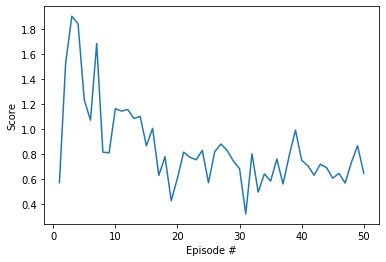

_BUFFER_SIZE         100000.0000
_BATCH_SIZE             128.0000
_GAMMA                    0.9900
_TAU                      0.0010
_LR_ACTOR                 0.0001
_LR_CRITIC                0.0001
_WEIGHT_DECAY             0.0000
_mu                       0.0000
_theta                    0.1500
_sigma                    0.1000
_actor_fc1_units        128.0000
_actor_fc2_units        128.0000
_critic_fc1_units       128.0000
_critic_fc2_units       128.0000
Name: 1, dtype: float64
Episode 50	Average Score: 9.21

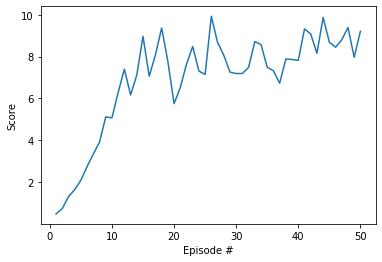

_BUFFER_SIZE         100000.0000
_BATCH_SIZE             128.0000
_GAMMA                    0.9000
_TAU                      0.0010
_LR_ACTOR                 0.0001
_LR_CRITIC                0.0001
_WEIGHT_DECAY             0.0000
_mu                       0.0000
_theta                    0.1500
_sigma                    0.1000
_actor_fc1_units        128.0000
_actor_fc2_units        128.0000
_critic_fc1_units       128.0000
_critic_fc2_units       128.0000
Name: 2, dtype: float64
Episode 50	Average Score: 23.72

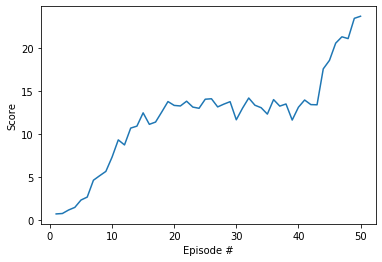

_BUFFER_SIZE         100000.0000
_BATCH_SIZE             128.0000
_GAMMA                    0.9000
_TAU                      0.0010
_LR_ACTOR                 0.0001
_LR_CRITIC                0.0001
_WEIGHT_DECAY             0.0000
_mu                       0.0000
_theta                    0.1500
_sigma                    0.1000
_actor_fc1_units         64.0000
_actor_fc2_units         32.0000
_critic_fc1_units        64.0000
_critic_fc2_units        32.0000
Name: 3, dtype: float64
Episode 50	Average Score: 27.61

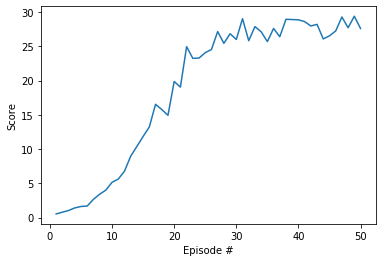

In [12]:
from tqdm import tqdm_notebook as tqdm

for index, row in tqdm(df_hyperparameters.iterrows()):
    print(row)
    agent = Agent(state_size, action_size, 2,
                int(row["_BUFFER_SIZE"]),
                int(row["_BATCH_SIZE"]),
                row["_GAMMA"],
                row["_TAU"],
                row["_LR_ACTOR"], 
                row["_LR_CRITIC"],
                row["_WEIGHT_DECAY"],
                row["_mu"],
                row["_theta"],
                row["_sigma"],
                int(row["_actor_fc1_units"]),
                int(row["_actor_fc2_units"]),
                int(row["_critic_fc1_units"]),
                int(row["_critic_fc2_units"]))
    plotscores(ddpg(agent, 50))

### Lessons learned from the hyperparameter search

Seeing the above results, the hyperparameter updates in the table impacts learning as below. (No. is the index in the hyperparameter table above.)

- From No. 1 to No. 2 : LR (Learning Rate) for the critic granurality is important to converge the learning.
- From No. 2 to No. 3 : Lower Gamma values accelerate learnings and even get better results. Impacts on the values obtained from the longer past actions/state affects relativerly smaller in this case.
- From No. 3 to No. 4 : Neural network size does not need to be large. It may be because the state is only 33, and the action is only 4 in this case.

Baed on the above considerations, here I run the experiment as the following.

### 5. Report version of hyperparemeters

Following is the hyper parameters used this time for reporting from the lessons obtained from the above guess.

#### Hyperparameters

In [13]:
_BUFFER_SIZE = int(1e6)  # replay buffer size
_BATCH_SIZE = 256        # minibatch size
_GAMMA = 0.90            # discount factor
_TAU = 1e-3              # for soft update of target parameters
_LR_ACTOR = 1e-4         # learning rate of the actor 
_LR_CRITIC = 1e-4        # learning rate of the critic
_WEIGHT_DECAY = 0        # L2 weight decay
_mu=0.                   # Ornstein-Uhlenbeck noise parameters
_theta=0.15              # Ornstein-Uhlenbeck noise parameters
_sigma=0.1               # Ornstein-Uhlenbeck noise parameters
_actor_fc1_units=64
_actor_fc2_units=32
_critic_fc1_units=64
_critic_fc2_units=32

In [14]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2,
    BUFFER_SIZE = _BUFFER_SIZE,  # replay buffer size
    BATCH_SIZE = _BATCH_SIZE,        # minibatch size
    GAMMA = _GAMMA,            # discount factor
    TAU = _TAU,              # for soft update of target parameters
    LR_ACTOR = _LR_ACTOR,         # learning rate of the actor 
    LR_CRITIC = _LR_CRITIC,        # learning rate of the critic
    WEIGHT_DECAY = _WEIGHT_DECAY,       # L2 weight decay
    mu = _mu,
    theta= _theta,
    sigma= _sigma)

#### Run the learning step and get the performance

Environment solved in 21 episodes with an Average Score of 30.21
Episode 100	Average Score: 30.06
Episode 120	Average Score: 30.63

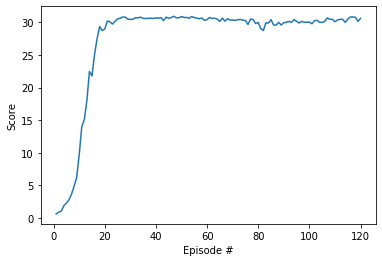

In [15]:
plotscores(ddpg(agent, 120))

This model reached to +30 at 21st episodes end. The learning result was stable to get score above +30.

### GPU usage

Following is the GPU (NVIDIA RTX 2060 usage) during the learning phase.
31% of utilization rate indicates, theare are more room for GPU usage to improve learning performant.
Also 1175MB is used out of 5904MB.

| NVIDIA-SMI 418.67   |   Driver Version: 418.67    |  CUDA Version: 10.1     |
|-------------------------------|----------------------|----------------------|
| GPU  Name        Persistence-M<br>Fan  Temp  Perf  Pwr:Usage/Cap| Bus-Id        Disp.A<br>Memory-Usage | Volatile Uncorr. ECC<br>GPU-Util  Compute M. |
|   0  GeForce RTX 2060    On<br>N/A   52C    P2    42W /  N/A   | 00000000:01:00.0 Off<br>1175MiB /  5904MiB |                  N/A<br>31%      Default |

### 6. Watch a Smart Agent!

From above the best model is stores as

* 'checkpoint_actor.pth' for actor newtork
* 'checkpoint_critic.pth' for critic network

Using these we can play the unity environemt, and get the score out of is as below.
We can see that good score can be obtained with those learned models.

In [16]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)                        # select an action (for each agent)
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))



Total score (averaged over agents) this episode: 38.93799912966788


When finished, you can close the environment.

In [17]:
env.close()

### Future Work for Improvements

This time the hyperparameters are adjusted to achive fast convergence to the target score 30.
But as can be seen in the GPU utilization, there are more rooms to use the GPU to make the learning phase faster.
Size of the Neural network and improving parralel execution of the learning can be consered here.

On the other hand, only the time for convergence is evaluated, but the stability of the learning is not evaluated here.
I should be better evaluate the stability of learning by evaluating the score distribution around the average score.